**<h1><center>CS 464</center></h1>**
**<h1><center>Introduction to Machine Learning</center></h1>**
**<h1><center>Spring 2022</center></h1>**
**<h1><center>Homework 3</center></h1>**
<h4><center>Due: DEC 23, 2022 23:59 (GMT+3)</center></h4>

In this third homework assignment, you are asked to develop a system that can be used to supply additional information to weather forecasts. For this task, you are provided a dataset that consists of weather images that belong to four different weather conditions: [cloudy, rain, shiny, sunrise]. Your model will classify images considering these class labels. 

For this assignment, **using PyTorch is mandatory.**

**Tip:** You may experience latencies in file I/O if you are using Google Colab. In this regard, we recommend you upload your data to Google Drive as a zip file and unzip the folder contents in your drive. If you would like to upload the data files separately, it may take significant time.

You will submit a single ipynb file as the homework submission. If you want to provide further explanation about your work, you can add Markdown cells to do so. [Here](https://www.markdownguide.org/), you can find a guide for Markdown syntax. Upload your homework with the following filename convention: \<BilkentID\>\_\<Name\>\_\<Surname\>.ipynb

**Contact:**
- [Yusuf Dalva](mailto:yusuf.dalva@bilkent.edu.tr)
- [Ahmet Burak Yıldırım](mailto:a.yildirim@bilkent.edu.tr)

**Dataset**<br>
You can find the dataset [here](https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset). 


# **Q1** [12 points]
This part consists of 4 questions which you are expected to answer. Please fill in the following cell in Markdown format. Each question is worth 2 points.

a) Do we need to output the actual probability values when performing classification with the softmax layer? If not, how do these numbers represent the likelihood of classes? Also, does the output values should be in a specific range for us to make a classification? <br>

b) From the perspective of model complexity, how you can identify when a model underfits or overfits? Which plots are informative for detecting this behavior? <br>

c) In neural networks, how does the ReLU function help us to generalize to conplex feature spaces? Why we are not using linear layers only? <br>

d) Assume that you are going to pass the feature matrix with dimensions 64x64x5 (Height x Width x Channel size) through a convolutional layer. If our convolutional layer has a kernel size of 3x3 and the number of filters is 6, how many learnable parameters are present? <br>

a) No, there is no need for the actual probabilities when performing classification with the softmax layer. The output of a softmax (these numbers) has the probabilities for each class, thus their likelihood. The output values may not be in a specific range for the classification but since they are probabilities, they should be between 0 and 1 and add up to 1.

b) Overfitting is caused by a model with a high level of complexity which fits the training data good but may not to validaiton data or test data. Underfitting is caused by a model with a low level of complexity which does not fit to the training data.
Learning curve (training and validation error). Overfitting can be understood if training loss is significantly less than validaiton loss. Underfitting can be understood if validation loss is significantly less than training loss. 

c)ReLU function gives non-linearity to the model so it can learn complex patterns in the data. Due to the non-linearity model can learn more complex patterns. With only linear layers, model can learn linear relationships. Also, use of ReLU function makes the model to learn faster and  effective. 

d) 3 * 3 * 5 = 45 parameters per filter
45*6 = 270 learnable parameters are present.

# **Q2** [88 points]

## Necessary Imports
In the cell below, we import some utilities that you can make use of in this assignment. Note that you need to use PyTorch in this assignment. To report certain metrics (like precision, recall, accuracy) you may use utilities from *scikit-learn* library. You can edit these imports considering your implementation as long as you use PyTorch.

## Setup

In [ ]:
import os 
import time
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

You can test whether hardware acceleration with GPU is enabled in the cell below. In addition, if you have GPU access, you can check the amount of available GPU memory.

In [ ]:
# setting device as GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# CUDA device information
if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Memory Stats:')
    print('  - Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('  - Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('  - Total:    ', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using device: cuda
GPU Name: Tesla T4
Memory Stats:
  - Allocated: 0.0 GB
  - Cached:    0.0 GB
  - Total:     14.8 GB


**DO NOT CHANGE**<br>
To evaluate your implementation fairly, we set seed values for random sampling methods in PyTorch, Numpy, and Python random library. These seeds are set to evaluate your models successfully, so do not change these values.

In [ ]:
# for reproducable results
torch.manual_seed(464)
torch.cuda.manual_seed(464)
np.random.seed(464)
random.seed(464)
if device.type == 'cuda':
    torch.backends.cudnn.deterministic=True

## Load Data [6 points]
In this assignment, you will use a custom dataset, which you need a wrapper class to access its data. For this purpose, implement a custom dataset class to organize data with the specifications you need. This class will load batches of data using a PyTorch DataLoader later. The class signature of CustomDataset class is provided to you in the cell below, where you can implement your custom dataset.

**IMPORTANT:** As you may have difficulties while fitting all images to your RAM, you need to read the images while getting that item (each item is an image here). We encourage you to read the data files in the "__getitem__" function to avoid encountering any issues related to fitting the data to memory. This way, you do not need to hold the dataset in a single variable, which would be memory intensive.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, **kwargs):
        self.data = data
        self.labels = labels

    '''This function should return sample count in the dataset'''
    def __len__(self):
        return len(self.data)

    '''This function should return a single sample and its ground truth value from the dataset corresponding to index parameter '''
    def __getitem__(self, index):
        return self.data[index], self.labels[index]

You can implement an additional function to read and construct custom dataset objects for training, validation, and test sets. While constructing the dataset, consider the following issues:
- Dataset contains images that end with prefixes *.jpg* and *.jpeg*.
- If you use PIL to read images, you should convert them to "RGB" format to operate on three color channels.
- Resize the dataset images to 224x224. You are going to design models that take images with tensor shape 224x224x3.
- If you wish, you can change the ordering of the color channels with np.moveaxis function

Lastly, the train-validation-test split for the dataset provided to you is 70-10-20 in terms of percentages. While constructing the dataset, remember that shuffling is a necessary step (to get randomly distributed classes across batches).

You can design your dataset getter method compatible with the line provided below, where train_dataset, val_dataset, and test_dataset are all instances of CustomDataset.

In [ ]:
transform_with_resize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

tensor_to_image = transforms.Compose([transforms.ToPILImage()])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data= []
datalabel = []
for folder in os.listdir("/content/drive/MyDrive/Multi-class Weather Dataset"):
  folder_name = "/content/drive/MyDrive/Multi-class Weather Dataset/" + folder
  for filename in os.listdir(folder_name):
    dir    = folder_name + "/" + filename
    img    = Image.open(dir).convert('RGB')
    resized = transform_with_resize(img)
    sample = resized
    if folder == "Shine":
      datalabel.append(0)
    if folder == "Cloudy":
      datalabel.append(1)
    if folder == "Rain":
      datalabel.append(2)
    if folder == "Sunrise":
      datalabel.append(3)
    data.append(sample)

data = np.array(data)
datalabel = np.array(datalabel)
datalabel = datalabel.reshape(1125,1)

trainX, testX, trainY, testY = train_test_split(data, datalabel, test_size=0.2, random_state=42)   
trainX, valX,  trainY, valY  = train_test_split(trainX, trainY, test_size=0.125, random_state=42)

train_dataset = CustomDataset(trainX, trainY)
val_dataset   = CustomDataset(valX, valY)
test_dataset  = CustomDataset(testX, testY)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-18-4d01ad383e8e>:23: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data = np.array(data)
<ipython-input-18-4d01ad383e8e>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


## Models [16 points]
In this assignment, you will implement one CNN (Convolutional Neural Network) model and one FCN (Fully-Connected Network) model, where the class signatures are provided below.

### Convolutional Neural Network (CNN) Model [8 points]
As the first model, you will implement a convolutional model. Your model will include 3 CONV + POOL blocks, which denotes one Convolutional layer followed by a Max Pooling Layer. The channel sizes for convolutional blocks are [16, 32, 64], respectively. For all convolutional layers, take kernel size as 3, stride as one, and apply padding such that convolutions do not change the shape on width and height dimensions. 
<br><br>
Following the convolutional part, you will perform image classification for the dataset provided to you. You can use ReLU activation as the non-linearity in your model (except the classification layer).

In [ ]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3,  16, kernel_size=3, padding=1,stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1,stride=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1,stride=1)
        self.mp = nn.MaxPool2d(2)
        self.fc = nn.Linear(50176, 4)

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        x = F.relu(self.mp(self.conv3(x)))
        x = x.contiguous()
        in_size = x.size(0)
        x = x.view(in_size, -1)
        x = self.fc(x)
        return x


### Fully Connected Network (FCN) Model [8 points]
The second model you will try is a Fully Connected Network composed of Linear layers and non-linear activation functions connected to each other. For this part, the number of features for your linear layers is [1024, 512, 256]. Again, you can use ReLU as your non-linear activation function in your model (except the classification layer).

In [ ]:
class FCNet(nn.Module):
    '''Define your full connected network'''
    def __init__(self, **kwargs):
        super(FCNet, self).__init__()      
        self.fc1=nn.Linear(150528, 1024)
        self.fc2=nn.Linear(1024, 512)
        self.fc3=nn.Linear(512, 256)
        self.fc4=nn.Linear(256, 4)

     
    def forward(self, x):
        in_size = x.size(0)
        x = x.view(-1,150528)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

## Training and Evaluation of FCN [22 points]

Now that you implemented the model definition of CNN and FCN, you will train these models with the hyperparameters you chose. The hyperparameters that you may change are listed in the cell below. Using the FCN model defined, train a classifier that predicts weather condition classes specified by the dataset. For the optimizer, use [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) optimizer provided by PyTorch. You should try out different hyper-parameters like learning rates, epochs, momentum, and weight decay. For [momentum](https://machinelearningmastery.com/gradient-descent-with-momentum-from-scratch/) and [weight decay](https://paperswithcode.com/method/weight-decay), you can read about these concepts if you are interested.

While training your model, save your best model over different epochs. You must select an appropriate metric to define the best model at a time step. You can implement the training procedure in the cell below. If you want to explain the reasoning behind your metric selection, you can add a markdown cell and provide your comments.

### Training [12 points]

In [ ]:
# TODO: training loop + eval FCN

model = FCNet()

optimizer = torch.optim.SGD(model.parameters(), lr=5e-2, momentum = 0.5, weight_decay = 5e-04)
criterion = nn.CrossEntropyLoss()
def val():       
    vl_loss = 0
    correct = 0
    for i, (data, target) in enumerate(val_loader):
        data, target = Variable(data), Variable(target)
        target = target.reshape(-1)

        output = model(data)
        
        loss = criterion(output, target)
        vl_loss += loss.item()
        
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    vl_accuracy = 100. * correct / len(val_loader.dataset)
    vl_accuracy = vl_accuracy.item()
    val_loss.append(loss.item())
    val_accuracy.append(vl_accuracy)

    print("Validation Loss     " + str(epoch) + " : " + str(loss.item()))
    print("Validation Accuracy " + str(epoch) + " : " + str(vl_accuracy))


def train(epoch):       
    model.train()
    tr_loss = 0
    correct = 0
    for i, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        target = target.reshape(-1)

        optimizer.zero_grad()

        output = model(data)
        
        loss = criterion(output, target)
        tr_loss += loss.item()
        loss.backward()

        optimizer.step()
        
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    tr_accuracy = 100. * correct / len(train_loader.dataset)
    tr_accuracy = tr_accuracy.item()
    train_loss.append(loss.item())
    train_accuracy.append(tr_accuracy)
    print("Train Loss     " + str(epoch) + " : " + str(loss.item()))
    print("Train Accuracy " + str(epoch) + " : " + str(tr_accuracy))   
    val()


train_loss     = [] 
train_accuracy = [] 
val_loss       = [] 
val_accuracy   = [] 

for epoch in range(35):
    train(epoch)

Train Loss     0 : 1.1892406940460205
Train Accuracy 0 : 39.77128219604492
Validation Loss     0 : 1.1799920797348022
Validation Accuracy 0 : 48.67256546020508
Train Loss     1 : 1.5142641067504883
Train Accuracy 1 : 44.47268295288086
Validation Loss     1 : 1.150337815284729
Validation Accuracy 1 : 44.24778747558594
Train Loss     2 : 1.1949516534805298
Train Accuracy 2 : 57.68741989135742
Validation Loss     2 : 1.1497877836227417
Validation Accuracy 2 : 39.8230094909668
Validation Loss     3 : 1.5264776945114136
Validation Accuracy 3 : 40.70796585083008
Train Loss     4 : 0.660798966884613
Train Accuracy 4 : 47.395172119140625
Validation Loss     4 : 0.8407959938049316
Validation Accuracy 4 : 59.29203414916992
Train Loss     5 : 1.3894833326339722
Train Accuracy 5 : 59.212196350097656
Validation Loss     5 : 1.0571287870407104
Validation Accuracy 5 : 47.7876091003418
Train Loss     6 : 0.7617229223251343
Train Accuracy 6 : 66.45489501953125
Validation Loss     6 : 1.1551684141159058

### Learning Process Analysis [5 points]
Following the training step, you will now provide accuracy and loss plots over all epochs. For this, provide two plots:
- In the first plot, you will provide the value of the accuracy metric over epochs. Your plot should include two curves, one for the training set and the other for the validation set.
- For the second plot, provide the curve for loss values over epochs. Again your plot should include two curves, where one indicates loss on the training set and the second indicates loss for the validation set.

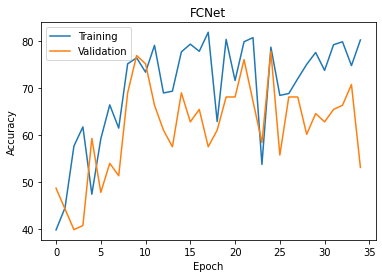

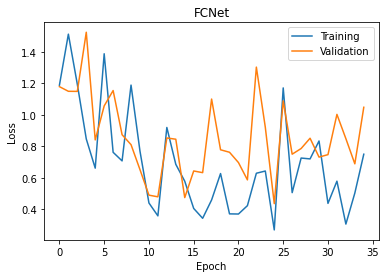

In [ ]:
# TODO: Implement your plots here, you can use matplotlib library to do so.

plt.plot(train_accuracy, label = "Training ")
plt.plot(val_accuracy,   label = "Validation")
plt.title("FCNet")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(train_loss, label = "Training ")
plt.plot(val_loss,   label = "Validation")
plt.title("FCNet")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Test [5 points]
As the final step of your analysis, you will test your model using some metrics. For the best model you obtained during training, evaluate your model on the test set. Then, report the confusion matrix. Finally, report accuracy, precision, recall, and $F_1$ score using your model. Report all these metrics using the macro form (macro precision, macro recall, etc.). You can implement these metrics in the cell below. 

In [ ]:
# TODO: Implement your evaluation script here, provide the confusion matrix and the requested metrics
def test():
    predictions = []
    labels = []
    for data, target in test_loader:
        
        data, target = Variable(data), Variable(target)
        label = target.reshape(-1)
        label = target.numpy()
        for i in range (len(label)):
          labels.append(label[0]) 
        
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1]
        pred = pred.numpy()
        for i in range (len(pred)):
          predictions.append(pred[0])  
    return predictions,labels

predictions, target = test()

confusionmatrix = confusion_matrix(target, predictions)
accuracy        = accuracy_score(target, predictions)
precision       = precision_score(target, predictions, average = "macro")
recall          = recall_score(target, predictions, average = "macro")
f1              = f1_score(target, predictions, average = "macro")

print("Accuracy  :", accuracy)
print("Precision :", precision)
print("Recall    :", recall)
print("F1 score  :", f1)
print("Confusion matrix:")
print(confusionmatrix)

## Training and evaluation of CNN [22 points]
Similar to the FCN model, you will now train the CNN model that you defined before. Again you are free to try out different hyperparameters. This model also will classify weather images with the four classes provided by the dataset. As the optimizer, again, use the SGD implementation provided by PyTorch. You can implement the training loop in the following cell. 

Similar to the training procedure, you need to save the best model you obtain during training. Select an appropriate criterion (metric) to save the best model. If you wish, you can add a markdown cell to explain your reasoning.

### Training [12 points]

In [ ]:
# TODO: training loop + eval CNN

model = ConvNet()

optimizer = torch.optim.SGD(model.parameters(), lr=5e-2, momentum = 0.5, weight_decay = 5e-04)
criterion = nn.CrossEntropyLoss()
def val():       
    vl_loss = 0
    correct = 0
    for i, (data, target) in enumerate(val_loader):
        data, target = Variable(data), Variable(target)
        target = target.reshape(-1)

        output = model(data)
        
        loss = criterion(output, target)
        vl_loss += loss.item()
        
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    vl_accuracy = 100. * correct / len(val_loader.dataset)
    vl_accuracy = vl_accuracy.item()
    val_loss.append(loss.item())
    val_accuracy.append(vl_accuracy)

    print("Validation Loss     " + str(epoch) + " : " + str(loss.item()))
    print("Validation Accuracy " + str(epoch) + " : " + str(vl_accuracy))


def train(epoch):       
    model.train()
    tr_loss = 0
    correct = 0
    for i, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        target = target.reshape(-1)

        optimizer.zero_grad()

        output = model(data)
        
        loss = criterion(output, target)
        tr_loss += loss.item()
        loss.backward()

        optimizer.step()
        
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    tr_accuracy = 100. * correct / len(train_loader.dataset)
    tr_accuracy = tr_accuracy.item()
    train_loss.append(loss.item())
    train_accuracy.append(tr_accuracy)
    print("Train Loss     " + str(epoch) + " : " + str(loss.item()))
    print("Train Accuracy " + str(epoch) + " : " + str(tr_accuracy))   
    val()


train_loss     = [] 
train_accuracy = [] 
val_loss       = [] 
val_accuracy   = [] 

for epoch in range(35):
    train(epoch)

KeyboardInterrupt: ignored

### Learning Process Analysis [3 points]
Repeating the same procedure you applied for the FCN model; you will provide two plots about how your training proceeds over epochs. Again, provide two plots: one summarizes the loss values, and the other summarizes the accuracy values. Note that each plot needs to include two curves, one for the validation set and the other for the training set.

In [ ]:
# TODO: Implement your plots here, you can use matplotlib library to do so.
plt.plot(train_accuracy, label="Training ")
plt.plot(val_accuracy, label="Validation")
plt.title("ConvNet")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(train_loss, label="Training ")
plt.plot(val_loss, label="Validation")
plt.title("ConvNet")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Test [4 points]
Concluding your analysis, report the confusion matrix for the best model you obtained during your CNN model training. Then using this confusion matrix, report accuracy, recall, precision, and $F_1$ score for your best model. Use macro averaging in all of your metrics.

In [ ]:
# TODO: Implement your evaluation script here, provide the confusion matrix and the requested metrics
def test():
    predictions = []
    labels = []
    for data, target in test_loader:
        
        data, target = Variable(data), Variable(target)
        label = target.numpy()
        for i in range (len(label)):
          labels.append(label[0]) 
        
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1]
        pred = pred.numpy()
        for i in range (len(pred)):
          predictions.append(pred[0])  
    return predictions,labels

predictions, target = test()

confusionmatrix = confusion_matrix(target, predictions)
accuracy        = accuracy_score(target, predictions)
precision       = precision_score(target, predictions, average = "macro")
recall          = recall_score(target, predictions, average = "macro")
f1              = f1_score(target, predictions, average = "macro")

print("Accuracy  :", accuracy)
print("Precision :", precision)
print("Recall    :", recall)
print("F1 score  :", f1)
print("Confusion matrix:")
print(confusionmatrix)

### Discussion [3 points]
Now, try to compare the two models that you trained. How different are these two models regarding the number of parameters used?

Explain your findings by connecting them with your experimental results. You can include your comments on a separate Markdown cell or below the question statement.

FCNet - fully connected layers- the number of parameters in an FCNet grows quadratically with the number of neurons in each layer. ConvNets consists of convolutional layers, which use filters to extract features. FCNets has more parameters than ConvNets because the input is large. ConvNets are more efficient and can be trained easily but FCNets are more powerful than ConvNets.



## Transfer Learning [22 points]

As the last part of this assignment, you will practice transfer learning. In this methodology, we aim to use models trained on large-scale datasets for our task. As we do not have access to large datasets and computational resources all the time, we sometimes try to use already trained models (on other datasets) as a good starting point for our model, and then fine-tune the weights considering our task.  

Torchvision library provides numerous models pretrained for specific tasks. [Here](https://pytorch.org/vision/stable/models.html), you can find a list of pretrained models. For this part, you will include [ResNet](https://arxiv.org/abs/1512.03385)-18 model, pretrained with ImageNet dataset. ImageNet is a large dataset where training from scratch would take a long time. You will fine-tune this pretrained module for your task. 
<br>
**Hint:** You can add a Linear layer to adapt the model to the number of classes needed for your task. You can access the number of inputs to the ResNet-18 model as $\texttt{model.fc.in_features}$ and then modify the fully connected layer of the model $\texttt{model.fc}$.
<br>

Using the ResNet-18 backbone, implement this model's training loop (by adapting it to your task). You can implement the training procedure in the cell provided below. Again save your model based on a criterion indicating the best model. Explain the reasoning for your criteria. Use the SGD optimizer provided by PyTorch to optimize your model.

Just like the previous parts, you can also tune your hyperparameters to optimize your model's performance. 

In [ ]:
model = models.resnet18(pretrained=True)
in_features = model.fc.in_features  
model.fc = torch.nn.Linear(in_features, 4)

###Training [12 points]

In [ ]:
# TODO: training loop + eval ResNet-18

optimizer = torch.optim.SGD(model.parameters(), lr=5e-2, momentum = 0.5, weight_decay = 5e-04)
criterion = nn.CrossEntropyLoss()
def val():       
    vl_loss = 0
    correct = 0
    for i, (data, target) in enumerate(val_loader):
        data, target = Variable(data), Variable(target)
        target = target.reshape(-1)

        output = model(data)
        
        loss = criterion(output, target)
        vl_loss += loss.item()
        
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    vl_accuracy = 100. * correct / len(val_loader.dataset)
    vl_accuracy = vl_accuracy.item()
    val_loss.append(loss.item())
    val_accuracy.append(vl_accuracy)

    print("Validation Loss     " + str(epoch) + " : " + str(loss.item()))
    print("Validation Accuracy " + str(epoch) + " : " + str(vl_accuracy))


def train(epoch):       
    model.train()
    tr_loss = 0
    correct = 0
    for i, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        target = target.reshape(-1)

        optimizer.zero_grad()

        output = model(data)
        
        loss = criterion(output, target)
        tr_loss += loss.item()
        loss.backward()

        optimizer.step()
        
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    tr_accuracy = 100. * correct / len(train_loader.dataset)
    tr_accuracy = tr_accuracy.item()
    train_loss.append(loss.item())
    train_accuracy.append(tr_accuracy)
    print("Train Loss     " + str(epoch) + " : " + str(loss.item()))
    print("Train Accuracy " + str(epoch) + " : " + str(tr_accuracy))   
    val()


train_loss     = [] 
train_accuracy = [] 
val_loss       = [] 
val_accuracy   = [] 

for epoch in range(10):
    train(epoch)

###Learning Process Analysis [3 points]
After training your model, provide two plots summarizing the learning procedure. Like previous parts, you will provide plots for loss value and accuracy progression over epochs. Remember that for each plot, you need to include two curves (one for the training set and one for the validation set).

In [ ]:
# TODO: Implement your plots here, you can use matplotlib library to do so.
plt.plot(train_accuracy, label="Training ")
plt.plot(val_accuracy, label="Validation")
plt.title("ResNet-18")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(train_loss, label="Training ")
plt.plot(val_loss, label="Validation")
plt.title("ResNet-18")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Test [4 points]
Following your analysis, report the confusion matrix for the best model you obtained (with the criteria you defined). Then, report the accuracy, precision, recall and $F_1$ score for the best model. In all of the metrics, use macro averaging.

In [ ]:
# TODO: Implement your evaluation script here, provide the confusion matrix and the requested metrics
def test():
    predictions = []
    labels = []
    for data, target in test_loader:
        
        data, target = Variable(data), Variable(target)
        label = target.numpy()
        for i in range (len(label)):
          labels.append(label[0]) 
        
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1]
        pred = pred.numpy()
        for i in range (len(pred)):
          predictions.append(pred[0])  
    return predictions,labels

predictions, target = test()


confusionmatrix = confusion_matrix(target, predictions)
accuracy        = accuracy_score(target, predictions)
precision       = precision_score(target, predictions, average="macro")
recall          = recall_score(target, predictions, average="macro")
f1              = f1_score(target, predictions, average="macro")

print("Accuracy  :", accuracy)
print("Precision :", precision)
print("Recall    :", recall)
print("F1 score  :", f1)
print("Confusion matrix:")
print(confusionmatrix)

### Discussion [3 points]
Now discuss the effectiveness of Transfer Learning. How does it improve performance?  

It improves the performance since it is pre-trained and already has learned some features. Since it is trained on a large dataset it has an advantage of being generalized to new tasks. Transfer learning is used to fine-tune the hyperparameters of the pre-trained model and learning rate chosen to be less. Due to all these reasons, transfer learning has a high performance. 

# References
[1] Ajayi, Gbeminiyi (2018), “Multi-class Weather Dataset for Image Classification”, Mendeley Data, V1, doi: 10.17632/4drtyfjtfy.1